In [1]:
import numpy as np
from numpy import genfromtxt
from trueskill import TrueSkill, Rating, quality_1vs1, rate_1vs1
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
from matplotlib import cm
from scipy import stats
import operator as op
import pandas as pd
from ast import literal_eval
from mpl_toolkits.mplot3d import Axes3D
import math
import sys

# Rastrigin function
## Optimization Methods
---
https://www.sfu.ca/~ssurjano/rastr.html

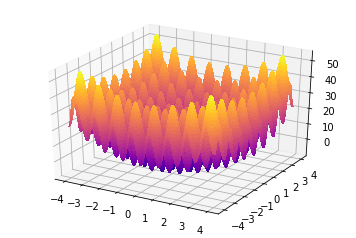

In [3]:
def rastrigin(*X, **kwargs):
    A = kwargs.get('A', 10)
    return A + sum([(x**2 - A * np.cos(2 * math.pi * x)) for x in X])

if __name__ == '__main__':
    X = np.linspace(-4, 4, 200)    
    Y = np.linspace(-4, 4, 200)    

    X, Y = np.meshgrid(X, Y)

    Z = rastrigin(X, Y, A=10)

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.plasma, linewidth=0, antialiased=False)    
    plt.savefig('rastrigin', format='pdf')

## Simulated Annealing
---
### Cooling Schedule

Now we must define the functions that constitute our cooling schedule. We reduce the temperature by a multiplicative factor of 0.8, and increase the epoch length by a factor of 1.2

In [4]:
tf = lambda t: 0.8*t #temperature function
itf = lambda length: math.ceil(1.2*length) #iteration function

### Running the Algorithm

We define the `sa` function that takes a set of initial conditions, on temperature, length of epoch, and starting point, the energy function, the number or opochs to run, the cooling schedule, and the proposal, and implements the algorithm defined above. Our algorithms structure is that of running for some epochs during which we reduce the temperature and increase the epoch iteration length. This is somewhat wasteful, but simpler to code, although it is not too complex to build in stopping conditions.

In [5]:
def sa(energyfunc, initials, epochs, tempfunc, iterfunc, proposalfunc):
    # out plot
    OUT_List_Simanneal = []
    Iterations = []
    
    accumulator=[]
    best_solution = old_solution = initials['solution']
    T=initials['T']
    length=initials['length']
    best_energy = old_energy = energyfunc(old_solution)
    accepted=0
    total=0
    
    best_index=total
    best_temp=T
    for index in range(epochs):
        # print("Epoch", index)
        if index > 0:
            T = tempfunc(T)
            length=iterfunc(length)
            sys.stdout.write("\r Temperature " + str(T))
            sys.stdout.flush()
        # print("Temperature", T, "Length", length)
        for it in range(length):
            Iterations.append(total)
            total+=1
            new_solution = np.copy(old_solution)
            for y in new_solution:
                if proposalfunc == 'rdmGauss':
                    y[0] = y[0] + rdmGauss(sigma = 0.7)
                else:
                    y[0] = y[0] + rdmSimetricPoerLow(x1 = 5, x0 = 0.1, alpha = -1.5)
                if y[0] < -5.12 :
                    y[0] = -5.12
                elif y[0] > 5.12:
                    y[0] = 5.12
                    
            # new_solution = proposalfunc(old_solution)
            new_energy = energyfunc(new_solution)
            # Use a min here as you could get a "probability" > 1
            alpha = min(1, np.exp((old_energy - new_energy)/T))
            if ((new_energy < old_energy) or (np.random.uniform() < alpha)):
                # Accept proposed solution
                accepted+=1
                accumulator.append((T, new_solution, new_energy))
                OUT_List_Simanneal.append(new_energy)
                if new_energy < best_energy:
                    # Replace previous best with this one
                    best_energy = new_energy
                    best_solution = new_solution
                    best_index=total
                    best_temp=T
                old_energy = new_energy
                old_solution = new_solution
            else:
                # Keep the old stuff
                accumulator.append((T, old_solution, old_energy))
                OUT_List_Simanneal.append(old_energy)
    
    best_meta=dict(index=best_index, temp=best_temp)
    # print("frac accepted", accepted/total, "total iterations", total, 'bmeta', best_meta)
    return best_meta, best_solution, best_energy, accumulator, OUT_List_Simanneal, Iterations

In [6]:
# http://mathworld.wolfram.com/RandomNumber.html
# https://stackoverflow.com/questions/918736/random-number-generator-that-produces-a-power-law-distribution
def rdmSimetricPoerLow(x1 = 5, x0 = 0.1, alpha = -1.5):
    y = np.random.uniform(0,1,1)
    x = math.pow((math.pow(x1, (alpha + 1)) - math.pow(x0, (alpha + 1)))*y + math.pow(x0, (alpha + 1)),(1/(alpha+1)))
    sign = np.random.uniform(0,1,1)
    return x if sign > 0.5 else -x

In [7]:
def rdmGauss(sigma = 0.2, mu = 0):
    return np.random.normal(mu, sigma, 1)

In [8]:
def Rastrigin(fevalMtx, A = 10):
    return A * fevalMtx.shape[0] + sum([(x[0]**2 - A * np.cos(2 * math.pi * x[0])) for x in fevalMtx])



In [9]:
def RastriginGradient(fevalMtx, A = 10):
    delta = np.zeros((fevalMtx.shape[0], 1))
    for i in range(fevalMtx.shape[0]):
        delta[i][0] = (fevalMtx[i][0] * 2) + (A * 2 * math.pi * np.sin(2 * math.pi * fevalMtx[i][0]))
   
    return delta

In [10]:
def min_RastriginPowerLaw(fevalMtx):
    Y = np.copy(fevalMtx)
    for y in Y:
        y[0] = y[0] + rdmSimetricPoerLow()
        
        if y[0] < -5.12 :
            y[0] = -5.12
        elif y[0] > 5.12:
            y[0] = 5.12
    
    prev = Rastrigin(fevalMtx);
    new = Rastrigin(Y);
    
    if new <= prev:
        return new, Y
    else:
        return prev, fevalMtx
            

In [11]:
def min_RastriginHill(fevalMtx):
    Y = np.copy(fevalMtx)
    for y in Y:
        y[0] = y[0] + rdmGauss(sigma = 0.7)
        
        if y[0] < -5.12 :
            y[0] = -5.12
        elif y[0] > 5.12:
            y[0] = 5.12
    
    prev = Rastrigin(fevalMtx);
    new = Rastrigin(Y);
    
    if new <= prev:
        return new, Y
    else:
        return prev, fevalMtx

In [12]:
def min_RastriginGradiente(fevalMtx, delta):
    alpha = 0.0001;
    miu = 0.7;
    grad = RastriginGradient(fevalMtx)
    Y = np.copy(fevalMtx)
    for i in range(fevalMtx.shape[0]):
        delta[i][0] =  miu * delta[i][0] - grad[i][0] * alpha
        Y[i][0] = Y[i][0] + delta[i][0]
        
        if Y[i][0] < -5.12 :
            Y[i][0] = -5.12
        elif Y[i][0] > 5.12:
            Y[i][0] = 5.12
    
    
    new = Rastrigin(Y);
    
    return new, Y, delta 

In [38]:
Best_List_PowerLaw = []
Best_List_HillRice = []
Best_List_Gradient = []
Best_List_GaussSimanneal = []
Best_List_PwrSimanneal = []

valVectorSize = 10
if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
avgIterations = 100

OUT_List_PowerLaw = []
OUT_List_HillRice = []
OUT_List_Gradient = []
OUT_List_PwrSimanneal = []
OUT_List_GaussSimanneal = []
    
for j in range(0, avgIterations):
    print("Iteration......................................: %i" % j)
    print("````````````````````````````````````````````````")
       
    Iterations = []
    
    fevalRdm =  np.random.uniform(low=-5, high=5, size=(valVectorSize, 1))
    delta = np.zeros((valVectorSize, 1))
    
    print("Initial X Set: %s" % ([",".join(item) for item in fevalRdm.astype(str)]) )

    powerLawMtx = np.copy(fevalRdm)
    hillMtx = np.copy(fevalRdm)
    gradientMtx = np.copy(fevalRdm)
    simannealMtx = np.copy(fevalRdm)
    
    
    for i in range(iterSize):
        PowerLaw_OUT, powerLawMtx = min_RastriginPowerLaw(powerLawMtx)
        if len(OUT_List_PowerLaw) == iterSize :
            OUT_List_PowerLaw[i] = OUT_List_PowerLaw[i] + PowerLaw_OUT
        else:
            OUT_List_PowerLaw.append(PowerLaw_OUT)
        Iterations.append(i)
    #-----

    for i in range(iterSize):
        HillRice_OUT, hillMtx = min_RastriginHill(hillMtx)
        if len(OUT_List_HillRice) == iterSize :
            OUT_List_HillRice[i] = OUT_List_HillRice[i] + HillRice_OUT
        else:
            OUT_List_HillRice.append(HillRice_OUT)
    #-----
    
    for i in range(iterSize):
        Gradient_OUT, gradientMtx, delta = min_RastriginGradiente(gradientMtx,delta)
        if len(OUT_List_Gradient) == iterSize :
            OUT_List_Gradient[i] = OUT_List_Gradient[i] + Gradient_OUT
        else:
            OUT_List_Gradient.append(Gradient_OUT)
    #-----
    print("Final PowerLaw_OUT %f Solution: %s" % (PowerLaw_OUT, [",".join(item) for item in powerLawMtx.astype(str)]))
    Best_List_PowerLaw.append(PowerLaw_OUT)
    
    print("Final HillRice_OUT %f Solution: %s" % (HillRice_OUT, [",".join(item) for item in hillMtx.astype(str)]))
    Best_List_HillRice.append(HillRice_OUT)
    
    print("Final Gradient_OUT %f Solution: %s" % (Gradient_OUT, [",".join(item) for item in gradientMtx.astype(str)]))
    Best_List_Gradient.append(Gradient_OUT)
    #-----
    inits=dict(solution=simannealMtx, length=70, T=17)
    
    bmeta, bs, be, out, OUT_List_PwrSimanneal_Tmp, Iterations_PwrSimanneal = sa(Rastrigin,
                                                                            inits,
                                                                            SimannealItrSize,
                                                                            tf,
                                                                            itf,
                                                                            'rdmSimetricPoerLow')
    
    if len(OUT_List_PwrSimanneal) == 0:
        OUT_List_PwrSimanneal = [ b for b in OUT_List_PwrSimanneal_Tmp]
    else:
        OUT_List_PwrSimanneal[:] = [ (OUT_List_PwrSimanneal_Tmp[i] + OUT_List_PwrSimanneal[i]) for i in range(len(OUT_List_PwrSimanneal))]
        
    print("\n Final PwrSimanneal_OUT %f Solution: %s" % (be, [",".join(item) for item in bs.astype(str)]))
    Best_List_PwrSimanneal.append(be)
    #-----
    inits=dict(solution=simannealMtx, length=70, T=17)
    
    bmeta, bs, be, out, OUT_List_GaussSimanneal_Tmp, Iterations_GaussSimanneal = sa(Rastrigin,
                                                                                inits,
                                                                                SimannealItrSize,
                                                                                tf,
                                                                                itf,
                                                                                'rdmGauss')
    
    if len(OUT_List_GaussSimanneal) == 0:
        OUT_List_GaussSimanneal = [ b for b in OUT_List_GaussSimanneal_Tmp]
    else:
        OUT_List_GaussSimanneal[:] = [ (OUT_List_GaussSimanneal_Tmp[i] + OUT_List_GaussSimanneal[i]) for i in range(len(OUT_List_GaussSimanneal))]
        
    print("\n Final GaussSimanneal_OUT %f Solution: %s" % (be, [",".join(item) for item in bs.astype(str)]))
    Best_List_GaussSimanneal.append(be)


    
OUT_List_PowerLaw[:] = [x / avgIterations for x in OUT_List_PowerLaw]

OUT_List_HillRice[:] = [x / avgIterations for x in OUT_List_HillRice]

OUT_List_Gradient[:] = [x / avgIterations for x in OUT_List_Gradient]

OUT_List_PwrSimanneal[:] = [x / avgIterations for x in OUT_List_PwrSimanneal]

OUT_List_GaussSimanneal[:] = [x / avgIterations for x in OUT_List_GaussSimanneal]



Iteration......................................: 0
````````````````````````````````````````````````
Initial X Set: ['-3.198374760842466', '2.6432056077573973', '-1.1741344364348985', '-3.863433574428712', '-4.376773410345368', '1.7325663097941177', '1.9298860350772422', '4.535702064085687', '2.3531243089499263', '-1.5280030490400454']
Final PowerLaw_OUT 45.937004 Solution: ['-2.1831290189754053', '0.8515115473085031', '-0.9225886428645373', '-3.029570424670478', '-0.8872851586663298', '0.07408271261736092', '-1.7741612125564488', '1.0644167285013393', '1.0297014105538995', '0.015307064342917731']
Final HillRice_OUT 49.282301 Solution: ['0.0012700664588472244', '2.8557028382579612', '-1.2001284162909787', '-1.0081952466186046', '-0.9482951587740605', '0.04295139548646163', '-0.2563881643894469', '-0.025690007652068747', '3.092959123110799', '-2.0298292026135614']
Final Gradient_OUT 91.535697 Solution: ['-2.9848557010394803', '2.9848557010394825', '-0.9949586376523347', '-3.9797838603007

 Temperature 0.30624477466119404
 Final GaussSimanneal_OUT 43.773312 Solution: ['2.0813358567597158', '0.04090361129555764', '1.8322741328442067', '-0.07578885083223529', '1.9923037716499976', '-0.010036953080831117', '0.9637693014888215', '1.3409393158675744', '-2.0834810992527233', '0.03344461147820721']
Iteration......................................: 5
````````````````````````````````````````````````
Initial X Set: ['-0.2734562844599431', '-0.44795416283712175', '2.8790985260212354', '0.47252975799025343', '-1.9461865800602451', '0.17915667272491387', '2.3076591691769437', '2.5241519550623543', '0.7485515593514158', '2.8208030460552935']
Final PowerLaw_OUT 51.314967 Solution: ['-1.1100957733951353', '-0.8157167305910438', '2.96622309517693', '-0.9499989230915193', '-0.014187265002679222', '1.0629374101393194', '0.9736639098122951', '-2.2244433051217003', '-1.2149637963158137', '2.0636821244970043']
Final HillRice_OUT 28.011623 Solution: ['-1.086334314229207', '-0.08522844823841552'

 Temperature 0.30624477466119404
 Final PwrSimanneal_OUT 40.615355 Solution: ['-1.3071984822591187', '1.9518966978974739', '0.09693873906928104', '-2.0416813380352834', '0.9431797525318821', '-1.1178155223398194', '2.0477196556041335', '1.040158799797012', '-0.921814059307347', '-0.9523173013500192']
 Temperature 0.30624477466119404
 Final GaussSimanneal_OUT 42.755533 Solution: ['1.1399466533321825', '-1.15741356320636', '-3.0340389244654054', '1.0115301601840032', '0.9791873434213092', '-0.8343557861188833', '2.036788906891544', '-0.8552508453399237', '0.9301049244021191', '2.000522056176795']
Iteration......................................: 10
````````````````````````````````````````````````
Initial X Set: ['3.080099530609651', '2.978158085239669', '-0.48230255583428505', '3.267572159104544', '1.7910312370494346', '1.5716806793014326', '2.5702770382799054', '-0.21753651395118467', '-3.4502317936247726', '1.168690958549102']
Final PowerLaw_OUT 38.596532 Solution: ['1.9658606790873494'

 Temperature 0.30624477466119404
 Final PwrSimanneal_OUT 29.696799 Solution: ['0.8527514931206599', '1.0001133727689955', '-0.8489767959284655', '-1.1060643825470273', '1.1679652066623267', '-0.9662274935746691', '0.01027811755206838', '0.8440838570772053', '0.9296571350759744', '0.9669494331234836']
 Temperature 0.30624477466119404
 Final GaussSimanneal_OUT 39.824839 Solution: ['0.0639110527516468', '0.038775808915911814', '0.018830869426822938', '0.18565485730454379', '-1.5473829867394862', '1.9762866573926137', '0.0671671103568541', '-1.0064431637369422', '-0.9783891099603671', '-1.1125113896641357']
Iteration......................................: 15
````````````````````````````````````````````````
Initial X Set: ['-3.0798494693679546', '3.4650691681820422', '-0.5559484438122899', '-3.259644259036377', '-0.16397695025982628', '-4.21258247445853', '-2.439969146708595', '-2.661746719640928', '3.9586300267311696', '0.5414241498401466']
Final PowerLaw_OUT 36.106337 Solution: ['0.932044

 Temperature 0.30624477466119404
 Final PwrSimanneal_OUT 47.359368 Solution: ['3.1502884746697717', '1.939502866828012', '2.1126749218544845', '2.97503638156137', '0.9943848618670187', '1.9382276498303077', '0.09434566194471938', '0.029124919390958515', '-0.9143143610483787', '-1.105837967118419']
 Temperature 0.30624477466119404
 Final GaussSimanneal_OUT 46.243837 Solution: ['1.8319787699036771', '0.02086846882260418', '-2.0370027782101747', '-4.00198684120725', '-0.9669239380543138', '2.090315890245724', '0.03093002079496654', '-1.9305678738813976', '-0.07917353832072506', '1.9618918129876182']
Iteration......................................: 20
````````````````````````````````````````````````
Initial X Set: ['-0.8475480725659974', '2.6568628865259374', '4.275331188133984', '-1.1833825218117724', '4.4585090955293545', '-3.573739172586566', '4.045176585143778', '0.9478482554128096', '1.1985398815743151', '2.7330217233175187']
Final PowerLaw_OUT 42.987864 Solution: ['2.0418581885105', 

 Temperature 0.30624477466119404
 Final PwrSimanneal_OUT 47.094866 Solution: ['-2.9641482737426266', '-0.012673525848245742', '0.7967808790354238', '-1.933138332256505', '-0.9316882566403341', '3.0760737145163426', '0.08919115397150391', '2.907102900437509', '0.9936857773983435', '0.05897162384752898']
 Temperature 0.30624477466119404
 Final GaussSimanneal_OUT 46.886935 Solution: ['-1.1155534252034784', '0.11166488203524694', '-1.8777051170926435', '0.6836916115415199', '2.178081983427891', '-0.019934051805387237', '1.0955033691664828', '-1.0036908317420086', '2.0316036799730686', '0.07718099657835562']
Iteration......................................: 25
````````````````````````````````````````````````
Initial X Set: ['-2.5198555921088084', '2.0460137744652984', '0.12395171305818131', '0.08412113538033861', '-2.7545322557607035', '-3.039822010443162', '-3.8260500871624803', '-4.78424937518323', '0.6958645137677077', '4.97827292399225']
Final PowerLaw_OUT 39.571827 Solution: ['0.9413023

 Temperature 0.30624477466119404
 Final PwrSimanneal_OUT 31.730612 Solution: ['-0.7825132121507001', '-1.0737352793066146', '-0.08658016114190868', '0.9946473311761618', '-0.015822973289517955', '1.1797443652092088', '0.07932212112737694', '0.12371554655722794', '0.15723522760174702', '-0.9007373137439173']
 Temperature 0.30624477466119404
 Final GaussSimanneal_OUT 57.397952 Solution: ['-3.906408653307108', '1.8652456688538588', '1.962696358937234', '-2.9029771384430427', '1.9894067686053696', '-1.135892400885668', '-0.9260799843105346', '-0.9966520675807415', '0.8931808734766785', '2.0491060624889643']
Iteration......................................: 30
````````````````````````````````````````````````
Initial X Set: ['4.733907773616059', '1.3797951918042974', '2.85884682948773', '-1.7361398900530367', '-2.6401903614955757', '-3.4571391994769654', '3.3398021215487734', '-2.810754634762728', '0.14412985995418737', '1.3278491912558854']
Final PowerLaw_OUT 33.833324 Solution: ['0.98151046

 Temperature 0.30624477466119404
 Final PwrSimanneal_OUT 42.264537 Solution: ['0.5048603215868854', '2.0487886041858423', '-0.036688340842314426', '0.029644016497123116', '0.9781777515655087', '0.1752207648740925', '-0.9457353464534838', '-0.9381924557276969', '0.18574156855556245', '-0.9663682274269121']
 Temperature 0.30624477466119404
 Final GaussSimanneal_OUT 37.656340 Solution: ['2.012781954654925', '-0.9644635067469121', '-1.809572865724814', '0.03590489645251166', '-1.0969390365298295', '-0.8935727745744879', '2.2029765311870277', '0.030484149139946348', '1.018752268811617', '1.1053890507593993']
Iteration......................................: 35
````````````````````````````````````````````````
Initial X Set: ['-0.48236556462901703', '-1.677239596122726', '-1.6870857413662996', '0.8526670710845856', '3.3467986691353477', '-3.215822556661588', '-2.724841046092216', '-2.213849774566672', '-4.944204215492701', '3.4446344499198247']
Final PowerLaw_OUT 38.500861 Solution: ['-0.15393

 Temperature 0.30624477466119404
 Final PwrSimanneal_OUT 32.623018 Solution: ['0.04687674738287845', '0.9051661083338254', '-1.090935344401783', '0.8372081806983604', '-1.9637552315631792', '0.9097468431079636', '0.1874661853468871', '-1.1569768395226483', '0.9085152758091141', '0.0456319968356424']
 Temperature 0.30624477466119404
 Final GaussSimanneal_OUT 46.228827 Solution: ['-3.0725601984965', '-1.1655717399627121', '3.0168498708195286', '-1.1224447619554274', '-0.8198170471892876', '1.937712366099591', '-0.03785960080708767', '-0.9566801952041308', '-0.954166450906199', '-1.0802033083513103']
Iteration......................................: 40
````````````````````````````````````````````````
Initial X Set: ['2.190539957386762', '0.9043937685630699', '-1.0728441215270323', '3.467330229469038', '-0.21170437095132577', '-1.8370146091724626', '3.8872795858474394', '4.073690953177824', '4.59312113034896', '-2.303868949274891']
Final PowerLaw_OUT 53.313497 Solution: ['-2.890858388378479

 Temperature 0.30624477466119404
 Final PwrSimanneal_OUT 46.299959 Solution: ['-2.153328135051935', '-0.07027002706839702', '-0.02653087967500123', '-0.10644477392647109', '-3.0486412810420136', '0.14771727800489712', '-0.11685551149608414', '1.1197518858584743', '-0.21695171306268082', '0.8315976931457796']
 Temperature 0.30624477466119404
 Final GaussSimanneal_OUT 47.404546 Solution: ['-1.0604666737746442', '-1.9368115862326827', '-2.1845582049660397', '-2.0751030363817695', '1.0990785087936885', '0.04283618170990672', '2.006788510766527', '-1.8854720613903733', '1.1868582104601113', '1.1163745659021735']
Iteration......................................: 45
````````````````````````````````````````````````
Initial X Set: ['1.8015528743479763', '-2.0831916375193584', '0.6816617418051587', '2.2255367626915294', '-1.0999120762297157', '-0.7501091944398706', '-4.206039596268825', '-4.306156228913834', '1.8475642060668367', '1.4852602982774883']
Final PowerLaw_OUT 56.121872 Solution: ['1.86

 Temperature 0.30624477466119404
 Final PwrSimanneal_OUT 39.790099 Solution: ['-1.1659296026074801', '1.040860001642242', '-1.9843634859180381', '0.8908971566622499', '1.9418950823203103', '0.9894388108164119', '1.1926405965089923', '-1.9405069490725997', '0.1453968408267818', '0.8838987215737777']
 Temperature 0.30624477466119404
 Final GaussSimanneal_OUT 49.974719 Solution: ['1.0307172134310008', '-2.9990405145818757', '1.9398387671288566', '-2.135760434425376', '2.0653334582833214', '0.9641992372158711', '0.9615128790677537', '-1.7748244306218646', '-0.9030181874770913', '0.8356319733655161']
Iteration......................................: 50
````````````````````````````````````````````````
Initial X Set: ['-1.7275308832970682', '-2.5588169515126924', '-3.550582657849075', '4.5030241255178325', '2.4710357717193006', '-1.813222714661621', '-4.923999861559693', '-3.752541817859123', '-4.594477941254167', '0.42592683889346006']
Final PowerLaw_OUT 56.031111 Solution: ['1.92925643140966

 Temperature 0.30624477466119404
 Final PwrSimanneal_OUT 47.934771 Solution: ['2.1077022093613182', '1.0805091736363055', '-0.10857796943947906', '1.1042682682542213', '-0.0013900704346523352', '-3.21360558754677', '2.137232538307796', '-0.016432330064985373', '2.1156151454724266', '-0.027886525266524437']
 Temperature 0.30624477466119404
 Final GaussSimanneal_OUT 42.844052 Solution: ['1.06240976280614', '-1.9939273789012903', '-1.0777875773115664', '-0.7426510107760675', '-2.0297906184751766', '1.1869156127158855', '0.03565887145210178', '-1.916197632740732', '-0.9218457811687519', '-2.04000970665419']
Iteration......................................: 55
````````````````````````````````````````````````
Initial X Set: ['4.939509364157349', '-1.7177107092242991', '-1.8662523689723134', '4.577696456466617', '-0.10977486830021999', '-1.4416171144696799', '-0.34724716933229693', '1.5475352927347856', '2.144453621861219', '-1.3907527736506986']
Final PowerLaw_OUT 34.428832 Solution: ['1.0594

 Temperature 0.30624477466119404
 Final PwrSimanneal_OUT 42.279384 Solution: ['-0.2841437973554042', '-2.0311637542746794', '0.13498034611670404', '0.018109037403301276', '-1.754668443059126', '1.0797397076976314', '-0.968080182383874', '-0.02784611004848045', '-2.049947100654169', '-0.07590392276259572']
 Temperature 0.30624477466119404
 Final GaussSimanneal_OUT 24.937228 Solution: ['-0.03747989346286888', '-0.09033642068915815', '-2.089948956211367', '2.0434926152241424', '0.9430462844939201', '0.9116876001141427', '-0.05305892428684082', '0.9987654272380583', '-1.9075261604697369', '1.063951696779459']
Iteration......................................: 60
````````````````````````````````````````````````
Initial X Set: ['-3.0883737037390024', '2.7471333136946106', '3.087991166722853', '0.9113398497155698', '-0.15564806963306754', '-1.2869820251563056', '-0.1687788713731342', '2.3790556199050004', '-1.5966053112184184', '1.6053299657146392']
Final PowerLaw_OUT 38.454597 Solution: ['-0.9

 Temperature 0.30624477466119404
 Final PwrSimanneal_OUT 39.205646 Solution: ['1.1766770907963815', '0.05813853298496523', '-2.016549787321194', '0.00402413193993971', '2.146033318158746', '-0.9659625177671953', '0.9653283238208212', '1.018543548676997', '-0.6946260923649284', '1.0515529275359006']
 Temperature 0.30624477466119404
 Final GaussSimanneal_OUT 34.631201 Solution: ['1.0612180405840628', '0.2444145956306576', '-0.009268295134820081', '0.1530454274579498', '-1.919175054122536', '-0.8066981759445884', '1.0051204348796687', '2.059341225699914', '-0.048646687097747554', '0.03405956189220252']
Iteration......................................: 65
````````````````````````````````````````````````
Initial X Set: ['-4.2932046179976915', '-3.3888816294682442', '3.4435914641787964', '1.0501002567273412', '-1.1164921957245486', '-1.2292836213851634', '2.961805546525623', '-1.9601837666032584', '-1.2091250250110406', '0.10052818483055415']
Final PowerLaw_OUT 47.030888 Solution: ['1.1178219

 Temperature 0.30624477466119404
 Final PwrSimanneal_OUT 46.135051 Solution: ['0.2423054835101408', '-0.7877531926360527', '0.9366711871984356', '-0.1277186580708651', '0.09376774169237867', '-1.9629994049772292', '-1.9436395390847885', '1.1225443854807358', '1.9339454809381358', '-0.8534183415032569']
 Temperature 0.30624477466119404
 Final GaussSimanneal_OUT 54.475242 Solution: ['1.9841128591528174', '0.12640163133783705', '-0.7345371059300274', '-1.2164240445371857', '1.9757084916245908', '0.07621724838777946', '0.0204754128414526', '0.7482965556160105', '1.8210629569924528', '-0.09356145279749792']
Iteration......................................: 70
````````````````````````````````````````````````
Initial X Set: ['4.690597970704047', '3.5916233509976685', '4.25230823318833', '-1.3050353509069401', '-0.18067491077950049', '2.743794884955446', '-1.964020753383915', '-1.5075128965129592', '4.58873091248306', '-4.8352146655713355']
Final PowerLaw_OUT 44.116101 Solution: ['0.07533887694

 Temperature 0.30624477466119404
 Final PwrSimanneal_OUT 38.628304 Solution: ['-1.8490574032514027', '1.0355051275276357', '-0.03229400992443264', '-1.0211897294706058', '-0.7842784978249995', '1.2802054714361406', '-0.015425688463046677', '-2.029732729235387', '1.0074645860545988', '0.9858994501702409']
 Temperature 0.30624477466119404
 Final GaussSimanneal_OUT 52.293805 Solution: ['-0.06575936738462958', '1.9979585144203231', '-1.1766672689181805', '-1.7812387269777163', '1.3034138815213085', '-0.003185524148276161', '-0.8371960294517478', '0.18661643214869494', '0.9872144267236982', '1.0523851950305048']
Iteration......................................: 75
````````````````````````````````````````````````
Initial X Set: ['2.6772636425978824', '-3.836585988330948', '-2.3636526743216746', '-4.383838520289456', '2.5966208500217327', '-3.723698998362368', '-4.911671778086269', '-0.8942853659277699', '1.1573057291344586', '2.4222261497927002']
Final PowerLaw_OUT 44.591066 Solution: ['-2.14

 Temperature 0.30624477466119404
 Final PwrSimanneal_OUT 49.908456 Solution: ['1.0357865140075457', '1.0588273456947042', '-1.8949852412651995', '1.8836366024365694', '-1.864294732183579', '2.952678315182702', '-0.8858425695397799', '0.05782976121177774', '-1.2614900000992215', '0.8999094467593028']
 Temperature 0.30624477466119404
 Final GaussSimanneal_OUT 29.524539 Solution: ['-0.0919082634937492', '-0.017412082491857744', '-0.9361617432182727', '0.7515053036194212', '-1.0179590416542044', '-1.0796645253616477', '0.8733378477268107', '2.095224419292524', '0.09662231151323653', '0.05104837491561676']
Iteration......................................: 80
````````````````````````````````````````````````
Initial X Set: ['4.0638799551388765', '-1.6793716801441958', '-2.586131465638858', '3.6608752567759577', '2.440724324720323', '-0.050660472246622845', '-1.570672436845122', '-1.0939431938858348', '3.3593821040244', '2.6188167962632996']
Final PowerLaw_OUT 56.701637 Solution: ['1.0681176158

 Temperature 0.30624477466119404
 Final PwrSimanneal_OUT 47.040783 Solution: ['0.12680092371892948', '1.9296277299642322', '0.11725196710768959', '-1.9606161715858046', '-0.9117906675727743', '1.0873958885377586', '1.7128219208822468', '-0.9763352695778142', '0.993560119082864', '-3.067206332108598']
 Temperature 0.30624477466119404
 Final GaussSimanneal_OUT 38.883130 Solution: ['-0.9612411426642724', '1.984482722068891', '0.8048621790977002', '-0.10043257038616976', '-0.9764770594246012', '0.02921812147942554', '0.27147459896959103', '2.916496512525369', '-0.06537704205919188', '0.9681975990672875']
Iteration......................................: 85
````````````````````````````````````````````````
Initial X Set: ['-0.5740408488449598', '-3.0823518219961477', '-4.600896245932637', '-4.113553644550226', '-1.4899822264611262', '4.878702188567946', '-2.6340326268715373', '2.34802647572306', '2.72776383374727', '4.967730877736802']
Final PowerLaw_OUT 31.291391 Solution: ['-0.9077797435001

 Temperature 0.30624477466119404
 Final PwrSimanneal_OUT 40.266667 Solution: ['-1.9015525668852524', '-0.28457238573434485', '-0.20837993399012858', '-1.9049932583837568', '0.003026369870451129', '0.09451888689602997', '1.9934920833537186', '0.009223097035850766', '-0.010310815540905516', '-1.979346903290876']
 Temperature 0.30624477466119404
 Final GaussSimanneal_OUT 37.286543 Solution: ['-0.9404279990444566', '0.9478955714071857', '-0.6895246125897778', '1.0145974165565428', '-1.9954585823686302', '-0.09264126474147852', '1.9300654554151846', '2.004055788394708', '-0.8950181833642981', '0.9310978981958798']
Iteration......................................: 90
````````````````````````````````````````````````
Initial X Set: ['0.9716811035622985', '-0.4552161572284019', '3.7028062588323127', '-4.726321604846881', '0.7243788247985874', '-1.1353940563748233', '0.27927379774348804', '-4.900145600140675', '-2.026370401106349', '-0.053486098366297696']
Final PowerLaw_OUT 41.064828 Solution: [

 Temperature 0.30624477466119404
 Final PwrSimanneal_OUT 51.238608 Solution: ['1.0098891020217589', '-0.07118113532705439', '1.9402383916044559', '-2.905181512243952', '-1.9944997367651338', '1.0046151328221489', '-0.692267164780252', '1.9658267861627399', '0.8203984407252114', '1.9144684821473337']
 Temperature 0.30624477466119404
 Final GaussSimanneal_OUT 50.442561 Solution: ['-0.11024610458101014', '1.1739231278018067', '0.11965216989324734', '0.936103446692842', '-1.4591178381104961', '-0.9632832154252698', '0.1426138307243504', '0.07287707895377488', '-1.9937239233207378', '-2.0681830127747194']
Iteration......................................: 95
````````````````````````````````````````````````
Initial X Set: ['0.11129551395410608', '4.010318682858397', '1.821381155388564', '-4.211754090031041', '4.114958486704708', '-3.511321101129804', '3.9800329629878277', '-1.317823621475073', '4.423011716633722', '-1.89745915750261']
Final PowerLaw_OUT 46.765062 Solution: ['0.1639733621336210

 Temperature 0.30624477466119404
 Final PwrSimanneal_OUT 42.411272 Solution: ['-1.9018115070934458', '0.09371235572445302', '-0.050674229132515514', '-1.9654208122891328', '-1.8823905128811949', '-0.1527119494240995', '-1.989058667912892', '-2.2006073944622773', '-0.8815601846079992', '-1.0081766883267849']
 Temperature 0.30624477466119404
 Final GaussSimanneal_OUT 54.671064 Solution: ['-2.9353894411395127', '1.056809919844015', '-1.2937751196549843', '-0.027302545225819208', '-1.9967504910922032', '1.1848693870202627', '1.9031466892081317', '-0.013582772699250498', '3.0874553071184847', '-1.0162744415862082']


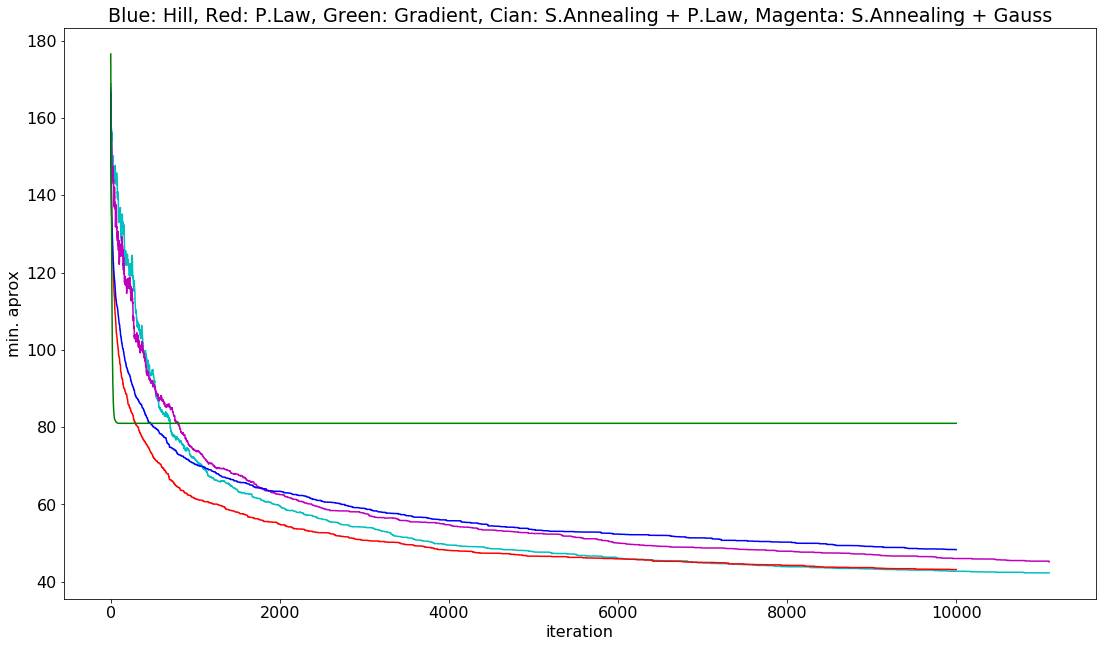

In [39]:
# plot the cost
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations_PwrSimanneal),
         np.squeeze(OUT_List_PwrSimanneal),
         'c-',
         np.squeeze(Iterations_GaussSimanneal),
         np.squeeze(OUT_List_GaussSimanneal),
         'm-',
         np.squeeze(Iterations),
         np.squeeze(OUT_List_PowerLaw),
         'r-',
         np.squeeze(Iterations),
         np.squeeze(OUT_List_HillRice),
         'b-',
         np.squeeze(Iterations),
         np.squeeze(OUT_List_Gradient),
         'g-',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("Blue: Hill, Red: P.Law, Green: Gradient, Cian: S.Annealing + P.Law, Magenta: S.Annealing + Gauss")
plt.savefig('rastriginMinCureveII.pdf', format='pdf')
plt.show()


Best PowerLaw mean 43.141751: 
Best PowerLaw std 7.544020: 


<function matplotlib.pyplot.show(*args, **kw)>

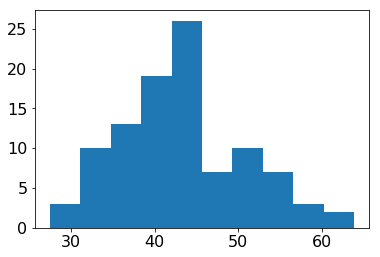

In [40]:
print("Best PowerLaw mean %f: " % np.mean(Best_List_PowerLaw))
print("Best PowerLaw std %f: " % np.std(Best_List_PowerLaw))
plt.hist(Best_List_PowerLaw)
plt.show

Best HillRice mean 48.311937: 
Best HillRice std 9.974385: 


<function matplotlib.pyplot.show(*args, **kw)>

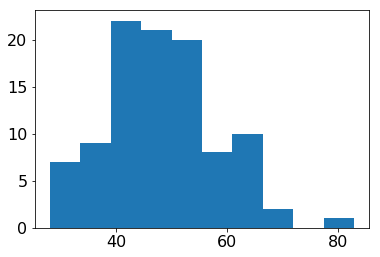

In [41]:
print("Best HillRice mean %f: " % np.mean(Best_List_HillRice))
print("Best HillRice std %f: " % np.std(Best_List_HillRice))
plt.hist(Best_List_HillRice)
plt.show

Best Gradient mean 80.989175: 
Best Gradient std 22.833178: 


<function matplotlib.pyplot.show(*args, **kw)>

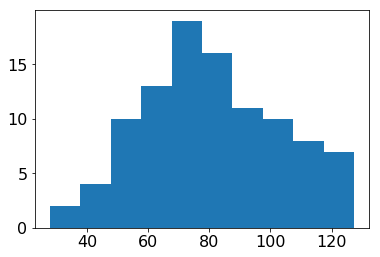

In [42]:
print("Best Gradient mean %f: " % np.mean(Best_List_Gradient))
print("Best Gradient std %f: " % np.std(Best_List_Gradient))
plt.hist(Best_List_Gradient)
plt.show

Best Best_List_PwrSimanneal mean 42.248725: 
Best Best_List_PwrSimanneal std 7.898463: 


<function matplotlib.pyplot.show(*args, **kw)>

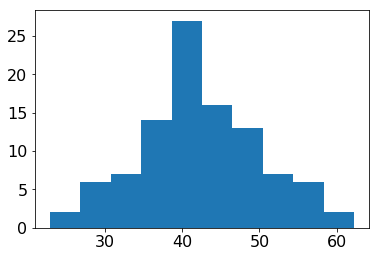

In [43]:
print("Best Best_List_PwrSimanneal mean %f: " % np.mean(Best_List_PwrSimanneal))
print("Best Best_List_PwrSimanneal std %f: " % np.std(Best_List_PwrSimanneal))
plt.hist(Best_List_PwrSimanneal)
plt.show

Best Best_List_GaussSimanneal mean 45.078055: 
Best Best_List_GaussSimanneal std 9.002060: 


<function matplotlib.pyplot.show(*args, **kw)>

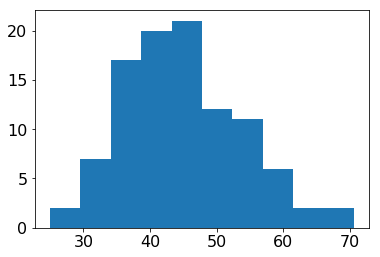

In [44]:
print("Best Best_List_GaussSimanneal mean %f: " % np.mean(Best_List_GaussSimanneal))
print("Best Best_List_GaussSimanneal std %f: " % np.std(Best_List_GaussSimanneal))
plt.hist(Best_List_GaussSimanneal)
plt.show
